In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys 
sys.path.append("../src/tarp/")
from drp import old_get_drp_coverage, get_drp_coverage, bootstrapping

### Changes:

The `get_drp_coverage` function now has a `seed` argument and a `norm` argument. 
You can still use the old function but its normalization can cause the tarp test to fail in specific cases, so we'd recommend to use the new one.  

Just to make sure there's no mistake, let's compare the old function and the new one...

Checking old - new
Expected coverage: 0.0
Credibility: 0.0


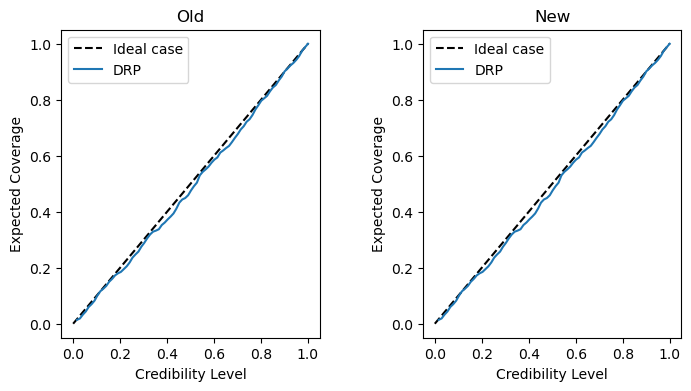

In [15]:
def generate_psd_matrix(n):
    # generate random array of appropriate size
    arr_size = int(n * (n - 1) / 2)
    arr = np.random.rand(arr_size)

    # convert array to symmetric matrix
    mat = np.zeros((n, n))
    triu_indices = np.triu_indices(n, k=1)
    mat[triu_indices] = arr
    mat += mat.T

    # check if matrix is positive semidefinite
    eigenvals = np.linalg.eigvalsh(mat)
    if np.all(eigenvals >= 0):
        return mat
    else:
        # if not, add identity matrix to make it PSD
        mat = mat + np.eye(n) * abs(eigenvals.min()) * 2
        return mat
    

def generate_correlated_samples(num_samples, num_sims, num_dims):
    """ Generate samples and true parameter values """
    theta = np.random.uniform(low=-5, high=5, size=(num_sims, num_dims))
    cov = [generate_psd_matrix(num_dims) for _ in range(num_sims)]
    cov = np.concatenate(cov).reshape(num_sims, num_dims, num_dims)
    samples = [np.random.multivariate_normal(mean=theta[i], cov=cov[i], size=num_samples) for i in range(num_sims)]
    samples = np.stack(samples)
    samples = samples.transpose(1, 0, 2)
    theta = [np.random.multivariate_normal(mean=theta[i], cov=cov[i], size=1) for i in range(num_sims)]
    theta = np.stack(theta)[:,0]
    return samples, theta

""" Main function """
samples, theta = generate_correlated_samples(num_samples=1000, num_sims=800, num_dims=10) # You can decrease the number of simulations for faster computation
old_ecp, old_alpha = old_get_drp_coverage(samples, theta, references='random', metric='euclidean', seed = 5)
ecp, alpha = get_drp_coverage(samples, theta, references='random', metric='euclidean', norm = True, seed = 5)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

def plot_coverage(ecp, alpha, ax_idx, title = ""):
    """
    Just a small utility function to plot the coverage
    """
    axs[ax_idx].plot([0, 1], [0, 1], ls='--', color='k', label = "Ideal case")
    axs[ax_idx].plot(alpha, ecp, label='DRP')
    axs[ax_idx].legend()
    axs[ax_idx].set_ylabel("Expected Coverage")
    axs[ax_idx].set_xlabel("Credibility Level")
    if title: 
        axs[ax_idx].set_title(title)
    


plot_coverage(old_ecp, old_alpha, 0, title = "Old")
plot_coverage(ecp, alpha, 1, title = "New")
plt.subplots_adjust(wspace=0.4)

print("Checking old - new")
print(f"Expected coverage: {np.abs((old_ecp - ecp).max())}")
print(f"Credibility: {np.abs((old_alpha - alpha).max())}")

### Test bootstrapping: 

The new `bootstrapping` function is only implemented for `get_drp_coverage`. This provides a method to offset the unpredictability of each tarp test. Bootstrapping seemed to be better suited than jackniffe for this situation because a large number of simulations is needed to have a reliable tarp test.

In [17]:
# This might take some time...
ecp_mean, ecp_std, alpha_mean = bootstrapping(samples, theta, references = "random", metric = "euclidean", norm = True)

100%|██████████| 800/800 [01:19<00:00, 10.09it/s]


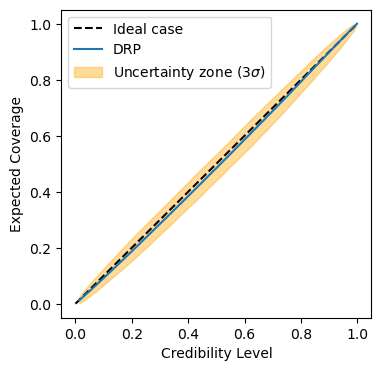

In [20]:
k_sigma = 3

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot([0, 1], [0, 1], ls='--', color='k', label = "Ideal case")
ax.plot(alpha, ecp, label='DRP')
ax.fill_between(alpha_mean, ecp_mean - k_sigma * ecp_std, ecp_mean + k_sigma * ecp_std, color = "orange", alpha = 0.4, label = f"Uncertainty zone ({k_sigma}" + r"$\sigma$)")
ax.legend()
ax.set_ylabel("Expected Coverage")
ax.set_xlabel("Credibility Level")
plt.show()